In [2]:
# import Section
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import isfile, join
import re
from matplotlib import pyplot as plt

In [3]:
def isjpg(filepath):
    return re.search(".jpg$", filepath)

In [4]:
# Function Section
def calculate_pad(brightness, saturation):
    p = 0.69*brightness + 0.22*saturation
    a = -0.31*brightness + 0.6*saturation
    d = 0.76*brightness + 0.32*saturation
    return [p,d,a]
    
def calculate_blur(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def mean_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    return np.mean(hsv[:,:,2])

def mean_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    return np.mean(hsv[:,:,1])

def calculate_opticalFlow(img1, img2):
    f, axarr = plt.subplots(2,1)
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    plt.show()
    prev = cv2.cvtColor(testEld[0], cv2.COLOR_BGR2GRAY)
    forward = cv2.cvtColor(testEld[1], cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(prev)
    mask[..., 1] = 255
    flow = cv2.calcOpticalFlowFarneback(prev, forward, flow=None, pyr_scale=0.5,levels =1,winsize=3,iterations=15,poly_n=3,poly_sigma=5,flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)[0]



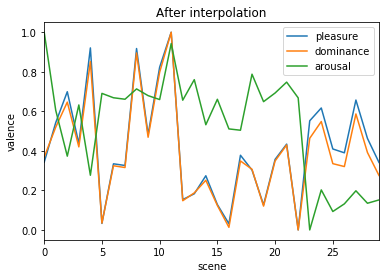

In [5]:
import glob
import re
from scipy.interpolate import interp1d

mypath = "data/scenes/big_hero_6"

files = [f for f in listdir(mypath) if isjpg(join(mypath, f))]
pad_data = []                                                                   
                                                                                
for fname in files:
    src = cv2.imread(join(mypath, fname),1)                                                    
    if(src is None):                                                            
        continue
    gx = '^[^-]*-([^-]*).*'
    p = re.compile(gx)
    scene = int(p.search(fname.replace('big_hero_6-','')).group(1))
    pad_data.append(calculate_pad(mean_brightness(src),mean_saturation(src)) + [scene])


    
df = pd.DataFrame(pad_data,columns=['pleasure','dominance','arousal', 'scene'] )
df = df.sort_values(by=['scene'],ascending=True)
df = df.groupby(['scene']).mean()
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df

ax2 = normalized_df.plot.line()
ax2.set_title('After interpolation')
ax2.set_xlabel("scene")
ax2.set_ylabel("valence")
normalized_df = normalized_df.reset_index()

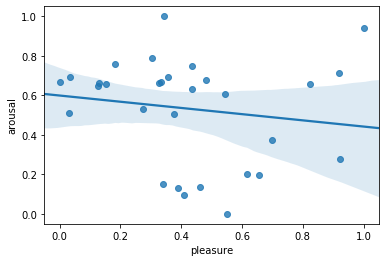

In [9]:
import seaborn as sns
sns.regplot(normalized_df['pleasure'],normalized_df['arousal'])

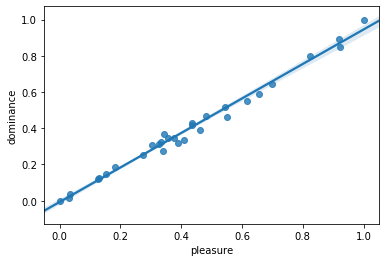

In [10]:
sns.regplot(normalized_df['pleasure'],normalized_df['dominance'])

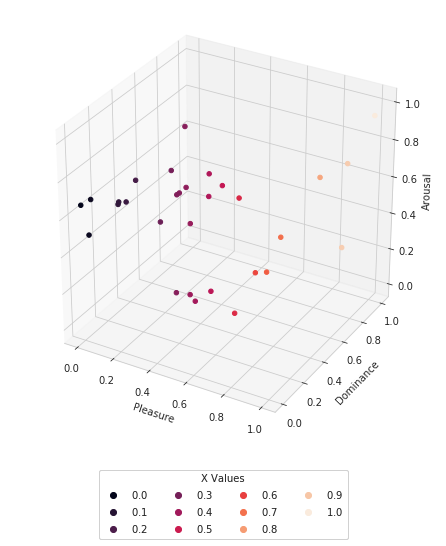

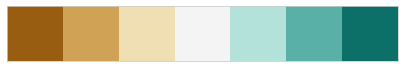

In [11]:
import seaborn as sns, numpy as np, pandas as pd, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)

x = normalized_df['pleasure'].tolist()
y = normalized_df['dominance'].tolist()
z = normalized_df['arousal'].tolist()

cm = sns.palplot(sns.color_palette("BrBG", 7))
g = ax.scatter(x, y, z, c=x, marker='o', depthshade=False, cmap=cm)
ax.set_xlabel('Pleasure')
ax.set_ylabel('Dominance')
ax.set_zlabel('Arousal')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*g.legend_elements(), loc="lower center", title="X Values", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

plt.show()

In [12]:
new_df = normalized_df.copy()
new_df['pleasure_diff'] = new_df['pleasure'].diff(-1)
new_df['pleasure_inflection'] = np.where(new_df['pleasure_diff'] > 0, 1, 0)
new_df[new_df['pleasure_inflection'].diff() != 0]['scene']

0      0
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
11    11
12    12
14    14
16    16
17    17
19    19
21    21
22    22
24    24
26    26
27    27
29    29
Name: scene, dtype: int64

In [13]:
ANGER_POINT = [-0.43, 0.67, 0.34]
JOY_POINT = [0.76, 0.48, 0.35]
SURPRISE_POINT = [0.4, 0.67, -0.13]
DISGUST_POINT = [-0.6, 0.35, 0.11]
FEAR_POINT = [-0.64, 0.6, -0.43]
SADNESS_POINT = [-0.63, 0.27, -0.33]


from scipy import spatial
kdtree = spatial.cKDTree(np.array([ANGER_POINT,JOY_POINT,SURPRISE_POINT,DISGUST_POINT,FEAR_POINT,SADNESS_POINT]))
mu = normalized_df.sample(1)
print(mu)
print(kdtree.data)
dist, ix = kdtree.query([mu['pleasure'].iloc[0],mu['arousal'].iloc[0],mu['dominance'].iloc[0]],k=2)
print(dist)
kdtree.data[ix]

    scene  pleasure  dominance   arousal
10     10  0.823251   0.797904  0.659519
[[-0.43  0.67  0.34]
 [ 0.76  0.48  0.35]
 [ 0.4   0.67 -0.13]
 [-0.6   0.35  0.11]
 [-0.64  0.6  -0.43]
 [-0.63  0.27 -0.33]]
[0.48666823 1.01993017]


array([[ 0.76,  0.48,  0.35],
       [ 0.4 ,  0.67, -0.13]])

In [56]:
df = pd.read_csv('clean_df.csv')
df = df[['scene_avg_p','scene_avg_a','scene_avg_d']]
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df

ANGER_POINT = [-0.43, 0.67, 0.34]
JOY_POINT = [0.76, 0.48, 0.35]
SURPRISE_POINT = [0.4, 0.67, -0.13]
DISGUST_POINT = [-0.6, 0.35, 0.11]
FEAR_POINT = [-0.64, 0.6, -0.43]
SADNESS_POINT = [-0.63, 0.27, -0.33]


from scipy import spatial
kdtree = spatial.cKDTree(np.array([ANGER_POINT,JOY_POINT,SURPRISE_POINT,DISGUST_POINT,FEAR_POINT,SADNESS_POINT]))
mu = normalized_df.sample(1)
print(mu)
print(kdtree.data)
dist, ix = kdtree.query([mu['scene_avg_p'].iloc[0],mu['scene_avg_a'].iloc[0],mu['scene_avg_d'].iloc[0]],k=3)
print(dist)
kdtree.data[ix]
def identify(row):
    dist, ix = kdtree.query([row['scene_avg_p'],row['scene_avg_a'],row['scene_avg_d']],k=3)
    arr = kdtree.data[ix]
    emotions = []
    for a in arr:
        if(([-0.43, 0.67, 0.34] == a).all()):
            emotions.append('Anger')
        elif(([0.76, 0.48, 0.35] == a).all()):
            emotions.append('Joy')
        elif(([0.4, 0.67, -0.13] == a).all()):
            emotions.append('Surprise')
        elif(([-0.6, 0.35, 0.11] == a).all()):
            emotions.append('Disgust')
        elif(([-0.64, 0.6, -0.43] == a).all()):
            emotions.append('Fear')
        elif(([-0.63, 0.27, -0.33] == a).all()):
            emotions.append('Sadness')
    return emotions
        
normalized_df['Emotion'] = normalized_df.apply(identify, axis=1)
df = pd.read_csv('clean_df.csv')
df['Emotion'] = normalized_df['Emotion']
df

     scene_avg_p  scene_avg_a  scene_avg_d
116     0.228381     0.441212     0.224525
[[-0.43  0.67  0.34]
 [ 0.76  0.48  0.35]
 [ 0.4   0.67 -0.13]
 [-0.6   0.35  0.11]
 [-0.64  0.6  -0.43]
 [-0.63  0.27 -0.33]]
[0.45550563 0.54760164 0.70650067]


,scene_name,scene_avg_p,scene_avg_a,scene_avg_d,scene_avg_blur,scene_avg_optical_flow,scene_movie,Emotion
0,big_hero_60,64.405538,72.981351,82.268261,204.102944,4.284929e-08,big_hero_6,"[Surprise, Joy, Anger]"
1,big_hero_61,76.658546,45.019868,93.268124,2058.214860,4.400276e-02,big_hero_6,"[Joy, Surprise, Anger]"
2,big_hero_610,93.844222,48.897762,113.486587,319.563208,7.499705e-03,big_hero_6,"[Joy, Surprise, Anger]"
3,big_hero_611,104.689522,68.900088,128.197153,344.318350,3.311605e-06,big_hero_6,"[Joy, Surprise, Anger]"
4,big_hero_612,52.825514,48.692155,66.235224,302.668920,1.479887e-03,big_hero_6,"[Surprise, Joy, Anger]"
5,big_hero_613,54.635902,56.085796,69.141541,373.148184,1.438304e-03,big_hero_6,"[Surprise, Joy, Anger]"
6,big_hero_614,60.207244,39.892563,73.756332,187.768550,1.667552e-03,big_hero_6,"[Surprise, Joy, Anger]"
7,big_hero_615,51.286053,48.994812,64.496347,81.434549,3.594452e-05,big_hero_6,"[Surprise, Joy, Anger]"
8,big_hero_616,45.333909,38.411284,56.466676,110.447071,NaN,big_hero_6,"[Surprise, Joy, Anger]"
9,big_hero_617,66.545265,37.953094,80.838276,609.955143,9.923468e-04,big_hero_6,"[Joy, Surprise, Anger]"
